# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

In [23]:
y=final['Score']

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [25]:
# printing some random reviews

sent_1500 = final['Text'].values[1500]
print(sent_1000)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first start by saying that everyone is looking for something different for their ideal tea, and I will attempt to briefly highlight what makes this tea attractive to a wide range of tea drinkers (whether you are a beginner or long-time tea enthusiast).  I have gone through over 12 boxes of this tea myself, and highly recommend it for the following reasons:<br /><br />-Quality:  First, this tea offers a smooth quality without any harsh or bitter after tones, which often turns people off from many green teas.  I've found my ideal brewing time to be between 3-5 minutes, giving you a light but flavorful cup

In [26]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [27]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...


In [29]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


In [31]:
# Combining all the above stundents 
from tqdm import tqdm
from bs4 import BeautifulSoup
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 46071/46071 [00:35<00:00, 1288.62it/s]


In [32]:
preprocessed_reviews[1500]

'great flavor low calories high nutrients high protein usually protein powders high priced high calories one great bargain tastes great highly recommend lady gym rats probably not macho enough guys since soy based'

In [33]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews, y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting

print(len(X_train), y_train.shape)
print(len(X_cv), y_cv.shape)
print(len(X_test), y_test.shape)

print("="*100)


20680 (20680,)
10187 (10187,)
15204 (15204,)


In [34]:
import collections, numpy
print(collections.Counter(y_train))
print(collections.Counter(y_cv))
print(collections.Counter(y_test))

Counter({1: 17227, 0: 3453})
Counter({1: 8449, 0: 1738})
Counter({1: 12803, 0: 2401})


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [35]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(X_train)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaaaaaaaaa', 'aaaaah', 'aaaand', 'aaf', 'aafco', 'aahhhs', 'aahing']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20680, 27246)
the number of unique words  27246


In [36]:
# we use the fitted CountVectorizer to convert the text to vector
#.transform to apply on train, cv and test which will give set 1 of vectorized data
set1_train = count_vect.transform(X_train)
set1_cv = count_vect.transform(X_cv)
set1_test = count_vect.transform(X_test)

print("After vectorizations")
print(set1_train.shape, y_train.shape)
print(set1_cv.shape, y_cv.shape)
print(set1_test.shape, y_test.shape)
print("="*100)

After vectorizations
(20680, 27246) (20680,)
(10187, 27246) (10187,)
(15204, 27246) (15204,)


In [38]:
from scipy import sparse
from scipy.sparse import csr_matrix,coo_matrix, hstack
#review length is calculated for train cv and tset datasets
set1a_train=csr_matrix(set1_train.sum(axis=1))
set1a_cv=csr_matrix(set1_cv.sum(axis=1))
set1a_test=csr_matrix(set1_test.sum(axis=1))

#To check dimension of newly created feature i.e. Review Length
print(set1a_train.get_shape())
print(set1a_cv.get_shape())
print(set1a_test.get_shape())

#Review length is stacked with bow features
set1_train_bow_rl=csr_matrix(hstack([set1_train,set1a_train]))
set1_cv_bow_rl=csr_matrix(hstack([set1_cv,set1a_cv]))
set1_test_bow_rl=csr_matrix(hstack([set1_test,set1a_test]))

#dimensions of bow+rev length dataset are printed for check
print(set1_train_bow_rl.get_shape())
print(set1_cv_bow_rl.get_shape())
print(set1_test_bow_rl.get_shape())

(20680, 1)
(10187, 1)
(15204, 1)
(20680, 27247)
(10187, 27247)
(15204, 27247)


In [39]:
I1=[]
I2=[]
I1.extend(count_vect.get_feature_names())
I2.extend(count_vect.get_feature_names())
I2.append("Rev_length")
print(len(I1))
print(len(I2))

27246
27247


In [41]:
scalar = StandardScaler(with_mean=False)
set1ss_train = scalar.fit_transform(set1_train)
set1ss_test= scalar.transform(set1_test)
set1ss_cv=scalar.transform(set1_cv)

C:\Users\Rajendra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Rajendra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Rajendra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Rajendra\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [42]:
print(set1ss_train.shape, y_train.shape)
print(set1ss_cv.shape, y_cv.shape)
print(set1ss_test.shape, y_test.shape)
print("="*100)

(20680, 27246) (20680,)
(10187, 27246) (10187,)
(15204, 27246) (15204,)


## [4.3] TF-IDF

In [132]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

set2_train= tf_idf_vect.transform(X_train)
set2_cv = tf_idf_vect.transform(X_cv)
set2_test = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(set2_train))
print("the shape of out text TFIDF vectorizer ",set2_train.get_shape())

print(set2_cv.shape, y_cv.shape)
print(set2_test.shape, y_test.shape)
print("the number of unique words including both unigrams and bigrams ", set2_train.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able drink', 'able eat', 'able find', 'able get', 'able give', 'able make', 'able order']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (20680, 12524)
(10187, 12524) (10187,)
(15204, 12524) (15204,)
the number of unique words including both unigrams and bigrams  12524


In [133]:
# we use the fitted CountVectorizer to convert the text to vector
#.transform to apply on train, cv and test which will give set 1 of vectorized data
set2_train = tf_idf_vect.transform(X_train)
set2_cv = tf_idf_vect.transform(X_cv)
set2_test = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(set2_train.shape, y_train.shape)
print(set2_cv.shape, y_cv.shape)
print(set2_test.shape, y_test.shape)
print("="*100)

After vectorizations
(20680, 12524) (20680,)
(10187, 12524) (10187,)
(15204, 12524) (15204,)


In [134]:
scalar = StandardScaler(with_mean=False)
set2ss_train = scalar.fit_transform(set2_train)
set2ss_test= scalar.transform(set2_test)
set2ss_cv=scalar.transform(set2_cv)

## [4.4] Word2Vec

In [142]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [143]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors


# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

# this line of code trains your w2v model on the give list of sentances
w2v_words = list(w2v_model.wv.vocab)

print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

[('awesome', 0.8387669324874878), ('good', 0.7819340229034424), ('wonderful', 0.7804070115089417), ('fantastic', 0.7782067656517029), ('excellent', 0.7780983448028564), ('amazing', 0.7660456299781799), ('perfect', 0.7556648254394531), ('decent', 0.6889456510543823), ('terrific', 0.6756653785705566), ('quick', 0.650530993938446)]
[('best', 0.8053455948829651), ('hottest', 0.7548017501831055), ('ive', 0.7493386268615723), ('horrendous', 0.7443078756332397), ('tasted', 0.7415162324905396), ('ever', 0.7347820997238159), ('hooked', 0.7314373254776001), ('humble', 0.7309339046478271), ('particular', 0.723179280757904), ('disgusting', 0.7167575359344482)]
number of words that occured minimum 5 times  8783
sample words  ['type', 'cat', 'food', 'cats', 'like', 'started', 'looking', 'cheapest', 'place', 'purchase', 'price', 'amazon', 'cheaper', 'big', 'box', 'store', 'normally', 'buy', 'groceries', 'plus', 'delivered', 'free', 'door', 'regular', 'schedule', 'never', 'run', 'make', 'emergency', '

In [144]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  8783
sample words  ['type', 'cat', 'food', 'cats', 'like', 'started', 'looking', 'cheapest', 'place', 'purchase', 'price', 'amazon', 'cheaper', 'big', 'box', 'store', 'normally', 'buy', 'groceries', 'plus', 'delivered', 'free', 'door', 'regular', 'schedule', 'never', 'run', 'make', 'emergency', 'trip', 'grocery', 'get', 'costco', 'prices', 'stink', 'switched', 'purina', 'one', 'mature', 'formulation', 'chicken', 'first', 'ingredient', 'many', 'foods', 'rice', 'products', 'specially', 'formulated', 'older']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [145]:
from tqdm import tqdm
import numpy as np

In [146]:
# average Word2Vec
# compute average word2vec for each review.
set3_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    set3_train.append(sent_vec)
set3_train = np.array(set3_train)
print(set3_train.shape)
print(set3_train[0])


100%|███████████████████████████████████████████████████████████████████████████| 20680/20680 [00:54<00:00, 378.52it/s]


(20680, 50)
[-0.30728893  0.46199177 -0.02787217  0.47813146 -0.05489253 -0.16938577
  0.39862451  0.17401722  0.5331249  -0.26639816  0.72280207 -0.72173776
 -0.57328134  1.33695068 -0.12930756 -0.12596377 -0.07462869  0.10321238
 -0.50356685 -0.05782816  0.22993928  0.11948922  0.12605031 -0.41884408
 -0.04096374  0.1631991  -1.14253744 -0.13064129  0.51420981 -0.38996335
  0.38965728  0.24556606 -0.46058909  1.36592816  0.22175322 -0.37694533
 -0.94181698  0.15612021  0.31122615  0.43887606  0.0486181   0.07384685
  0.65066672 -0.5860032   0.07701122 -0.54706009  0.22574702  0.36347028
  0.00603804  0.88662374]


In [147]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [148]:
# average Word2Vec
# compute average word2vec for each review.
set3_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    set3_cv.append(sent_vec)
set3_cv = np.array(set3_cv)
print(set3_cv.shape)
print(set3_cv[0])

100%|███████████████████████████████████████████████████████████████████████████| 10187/10187 [00:26<00:00, 382.17it/s]


(10187, 50)
[-0.53742462 -0.192087   -0.11484227  0.65535392 -0.13440646 -0.4807581
  0.41073134  0.18706472  0.38911345  0.07441175  0.34263836 -0.13075493
 -0.06878437  0.70072238 -0.44482831 -0.65596687 -0.55990489 -0.47225244
 -0.26561946  0.10979459  0.24158836  0.69004805  0.38285801 -0.10627348
  0.72801287 -0.20463536 -0.50940348  0.23892035 -0.20286853 -0.04588195
  0.12334398 -0.36664084 -0.00686174  0.6392497   0.39778602 -0.58941186
 -0.63346156  0.00099229 -0.17173091  0.29233553  0.13578024 -0.23737703
  0.89480802 -0.10721807 -0.1018734  -0.09130882 -0.1126526   0.54198172
  0.19154561  0.14621765]


In [149]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [150]:
# average Word2Vec
# compute average word2vec for each review.
set3_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    set3_test.append(sent_vec)
set3_test = np.array(set3_test)
print(set3_test.shape)
print(set3_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 15204/15204 [00:41<00:00, 391.27it/s]


(15204, 50)
[-0.42038391  0.12989492  0.03522889  0.41315049 -0.25843937 -0.52844429
  0.51186831  0.28768835  0.13704839  0.04044448  0.18174058 -0.25504471
  0.01438095  0.46725877 -0.07234854 -0.33874936 -0.31244848  0.49599909
 -0.25343405  0.20967122  0.22422737  0.40444823  0.07896331 -0.7028448
 -0.10386569  0.14923354 -0.26346159 -0.04243848  0.00145086 -0.02371219
  0.38521511 -0.32180038  0.01592135  0.6803362   0.25250413  0.20840275
 -1.04353714  0.1817047  -0.20088435  0.14403962 -0.31616745 -0.29454578
  0.60286929 -0.08997377  0.1761763  -0.14987676  0.18091652  0.2556378
 -0.00425527  0.27503949]


#### [4.4.1.2] TFIDF weighted W2v

In [175]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [176]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

set4_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    set4_train.append(sent_vec)
    row += 1
print(len(set4_train))
print(len(set4_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 20680/20680 [03:14<00:00, 106.12it/s]


20680
50


In [177]:
set4_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    set4_cv.append(sent_vec)
    row += 1
print(len(set4_cv))
print(len(set4_cv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 10187/10187 [01:34<00:00, 107.61it/s]


10187
50


In [178]:
set4_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    set4_test.append(sent_vec)
    row += 1
print(len(set4_test))
print(len(set4_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 15204/15204 [02:21<00:00, 107.74it/s]


15204
50


In [181]:
print(type(set4_train))

<class 'list'>


In [184]:
set4_train=np.array(set4_train)
set4_cv=np.array(set4_cv)
set4_test=np.array(set4_test)

print(set4_train.shape)
print(type(set4_train))

(20680, 50)
<class 'numpy.ndarray'>


# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [101]:
# Please write all the code with proper documentation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import  cross_val_score

#params_grid = {'n_estimators' = [20,40,60,80,100,120,140,160], 'max_depth'=[1,5,10,50,100,500,750,1000,1250]}
params_grid = {'n_estimators' : [20,40,60,80,100,120,140], 
               'max_depth': [1,5,10,50,100,250,500,750,1000,1250]}

rf = RandomForestClassifier(max_features='sqrt')

model_rf=GridSearchCV(rf,params_grid,scoring='roc_auc',n_jobs=-1,cv=3)
model_rf.fit(set1ss_train,y_train)

best_par = model_rf.best_params_
print(best_par)
scores = model_rf.cv_results_['mean_test_score']
print(scores)

{'max_depth': 750, 'n_estimators': 140}
[0.61824884 0.68339926 0.74203754 0.77217892 0.77002626 0.78609397
 0.79103321 0.79144108 0.82440999 0.84273259 0.84492375 0.85107202
 0.85964583 0.85359834 0.82341413 0.8510011  0.86119776 0.86054499
 0.86563671 0.86890435 0.86811153 0.84961915 0.87478527 0.87933716
 0.88438955 0.88577492 0.88738505 0.88634955 0.8575716  0.87639754
 0.88097651 0.88481272 0.88811342 0.88669861 0.88784784 0.85639764
 0.87891321 0.88232793 0.88802971 0.88858432 0.89087152 0.89055682
 0.85455562 0.87814789 0.88385374 0.88638108 0.88624831 0.88954377
 0.88995646 0.85051092 0.8785912  0.88121929 0.88732278 0.88650311
 0.88790008 0.89137557 0.86029647 0.87199792 0.8815269  0.88607104
 0.88865696 0.88860719 0.89040371 0.85847175 0.87833026 0.88495059
 0.8856184  0.88879348 0.88876796 0.89019074]


In [110]:
print(model_rf)
print(model_rf.best_index_)
print(model_rf.cv_results_)
#This and next cell are used to understand dimension of scores obtained in cross validation step

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [20, 40, 60, 80, 100, 120, 140], 'max_depth': [1, 5, 10, 50, 100, 250, 500, 750, 1000, 1250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)
55
{'mean_fit_time': array([  0.28208041,   0.48185786,   0.66330179,   0.85045711,
         1.041399  ,   1.20912576,   1.41108759,   0.74035939,
         1.33251913,   2.00773462,   2.65053606,   3.27430018,
       

       1.13364100e-04, 1.00664206e-04])}


In [103]:
ne=len(params_grid.get('n_estimators'))
md=len(params_grid.get('max_depth'))
n_e=params_grid.get('n_estimators')
m_d=params_grid.get('max_depth')
print(n_e)
print(m_d)

[20, 40, 60, 80, 100, 120, 140]
[1, 5, 10, 50, 100, 250, 500, 750, 1000, 1250]


In [104]:
scores=scores.reshape(md,ne)
print(scores)

[[0.61824884 0.68339926 0.74203754 0.77217892 0.77002626 0.78609397
  0.79103321]
 [0.79144108 0.82440999 0.84273259 0.84492375 0.85107202 0.85964583
  0.85359834]
 [0.82341413 0.8510011  0.86119776 0.86054499 0.86563671 0.86890435
  0.86811153]
 [0.84961915 0.87478527 0.87933716 0.88438955 0.88577492 0.88738505
  0.88634955]
 [0.8575716  0.87639754 0.88097651 0.88481272 0.88811342 0.88669861
  0.88784784]
 [0.85639764 0.87891321 0.88232793 0.88802971 0.88858432 0.89087152
  0.89055682]
 [0.85455562 0.87814789 0.88385374 0.88638108 0.88624831 0.88954377
  0.88995646]
 [0.85051092 0.8785912  0.88121929 0.88732278 0.88650311 0.88790008
  0.89137557]
 [0.86029647 0.87199792 0.8815269  0.88607104 0.88865696 0.88860719
  0.89040371]
 [0.85847175 0.87833026 0.88495059 0.8856184  0.88879348 0.88876796
  0.89019074]]


In [105]:
df1 = pd.DataFrame(scores, index = m_d , columns =n_e )
print(df1)

           20        40        60        80        100       120       140
1     0.618249  0.683399  0.742038  0.772179  0.770026  0.786094  0.791033
5     0.791441  0.824410  0.842733  0.844924  0.851072  0.859646  0.853598
10    0.823414  0.851001  0.861198  0.860545  0.865637  0.868904  0.868112
50    0.849619  0.874785  0.879337  0.884390  0.885775  0.887385  0.886350
100   0.857572  0.876398  0.880977  0.884813  0.888113  0.886699  0.887848
250   0.856398  0.878913  0.882328  0.888030  0.888584  0.890872  0.890557
500   0.854556  0.878148  0.883854  0.886381  0.886248  0.889544  0.889956
750   0.850511  0.878591  0.881219  0.887323  0.886503  0.887900  0.891376
1000  0.860296  0.871998  0.881527  0.886071  0.888657  0.888607  0.890404
1250  0.858472  0.878330  0.884951  0.885618  0.888793  0.888768  0.890191


Text(51.0, 0.5, 'max_depth')

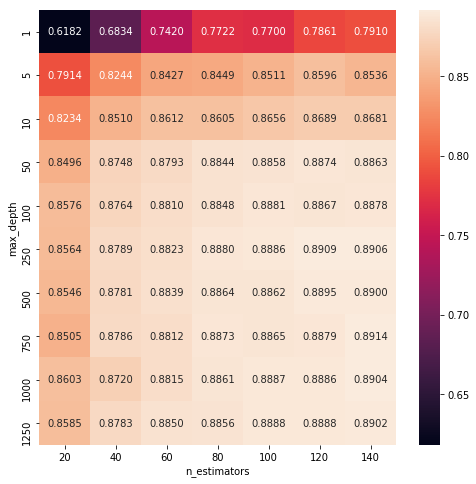

In [109]:
import seaborn as sns
plt.figure(figsize=(8, 8))
sns.heatmap(df1 , fmt=".4f", annot = True)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import  cross_val_score
import seaborn as sns
from sklearn.metrics import roc_auc_score

In [137]:
def gscv_rf(x_train,y_train,x_cv,y_cv):
    #params_grid = {'n_estimators' : [80,100], 'max_depth': [250,500,750]}
    params_grid = {'n_estimators' : [20,40,60,80,100,120,140], 'max_depth': [1,5,10,50,100,250,500,750,1000,1250]}
    rf = RandomForestClassifier(max_features='sqrt')

    model_rf=GridSearchCV(rf,params_grid,scoring='roc_auc',n_jobs=-1,cv=3)
    model_rf.fit(x_train,y_train)

    best_par = model_rf.best_params_
    print(best_par)
    scores = model_rf.cv_results_['mean_test_score']
    #print(scores)
    ne=len(params_grid.get('n_estimators'))
    md=len(params_grid.get('max_depth'))
    n_e=params_grid.get('n_estimators')
    m_d=params_grid.get('max_depth')
    scores=scores.reshape(md,ne)
    df1 = pd.DataFrame(scores, index = m_d , columns =n_e )

    plt.figure(figsize=(8, 8))
    sns.heatmap(df1 , fmt=".4f", annot = True)
    plt.xlabel('n_estimators')
    plt.ylabel('max_depth')
    return(best_par)

{'max_depth': 1000, 'n_estimators': 140}


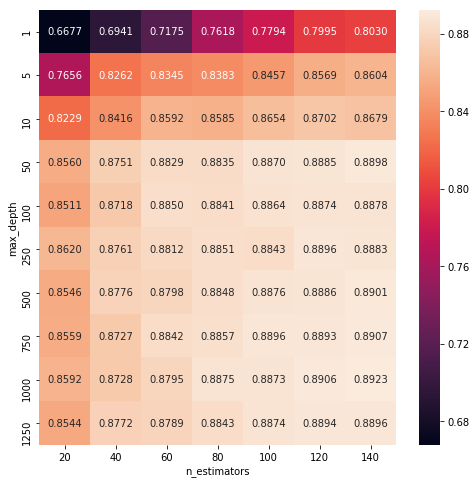

In [117]:
op=gscv_rf(set1ss_train,y_train,set1ss_cv,y_cv)

In [119]:
op_max_d1=op.get('max_depth')
op_n_est1=op.get('n_estimators')
print(op_max_d1)
print(op_n_est1)

1000
140


In [122]:
def test_rf(x_train,y_train,x_test,y_test,max_d,n_est):
    model=RandomForestClassifier(max_features='sqrt',max_depth=max_d,n_estimators=n_est)
    model.fit(x_train,y_train)

    train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(x_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    auc_test=auc(test_fpr, test_tpr)
    print('auc for Test data is::',auc_test)

    plt.legend()
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.title("AUC PLOTS")
    plt.show()

    print("="*100)


    yhat_train=model.predict(x_train)
    yhat_test=model.predict(x_test)

    con_mat_train = confusion_matrix(y_train, yhat_train)
    con_mat_test = confusion_matrix(y_test, yhat_test)

    plt.figure()
    class_label = ["negative", "positive"]
    df_con_mat_train = pd.DataFrame(con_mat_train, index = class_label, columns = class_label)
    sns.heatmap(df_con_mat_train , annot = True, fmt = "d")
    plt.title("Confusiion Matrix for Train data")
    plt.xlabel("Actual Label")
    plt.ylabel("Predicted Label")
    print("Train confusion matrix")
    print(con_mat_train)

    plt.figure()
    class_label = ["negative", "positive"]
    df_con_mat_test = pd.DataFrame(con_mat_test, index = class_label, columns = class_label)
    sns.heatmap(df_con_mat_test , annot = True, fmt = "d")
    plt.title("Confusiion Matrix for Test data")
    plt.xlabel("Actual Label")
    plt.ylabel("Predicted Label")
    plt.show()
    print("Test confusion matrix")
    print(con_mat_test)
    return(auc_test,model)



auc for Test data is:: 0.9029759853959677


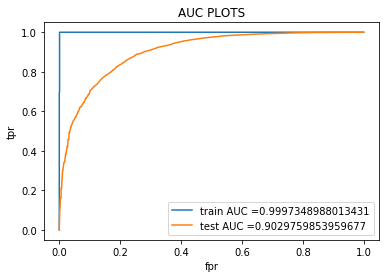

Train confusion matrix
[[ 3450     3]
 [    0 17227]]


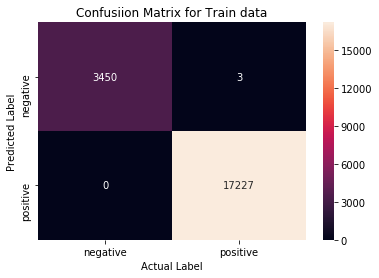

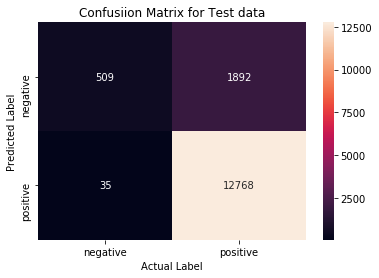

Test confusion matrix
[[  509  1892]
 [   35 12768]]


In [123]:
auc_set1,model1=test_rf(set1ss_train,y_train,set1ss_test,y_test,op_max_d1,op_n_est1)

In [124]:
print(auc_set1)
print(model1)

0.9029759853959677
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1000, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=140, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

In [129]:
# Please write all the code with proper documentation
def word_cloud(model,vect):
    all_features = vect.get_feature_names()
    data=''
    feat=model.feature_importances_
    features=np.argsort(feat)[::-1]
    for i in features[0:20]:
        data+=all_features[i]
        data+=' '
    
    from wordcloud import WordCloud
    wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return

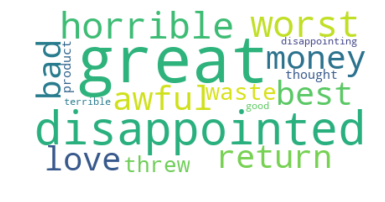

In [130]:
word_cloud(model1,count_vect)

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

{'max_depth': 750, 'n_estimators': 140}


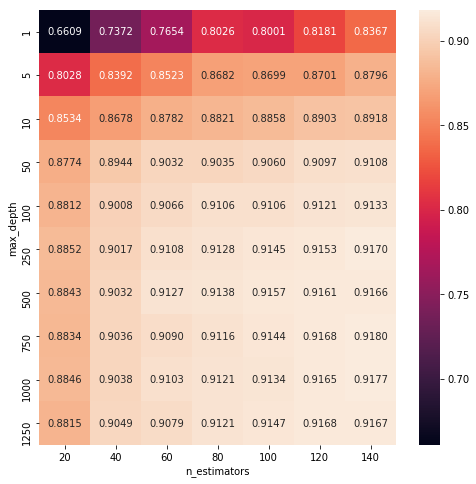

In [138]:
# Please write all the code with proper documentation
op2=gscv_rf(set2ss_train,y_train,set2ss_cv,y_cv)

In [139]:
# Please write all the code with proper documentation
op_max_d2=op2.get('max_depth')
op_n_est2=op2.get('n_estimators')
print(op_max_d2)
print(op_n_est2)

750
140


auc for Test data is:: 0.9246950789172012


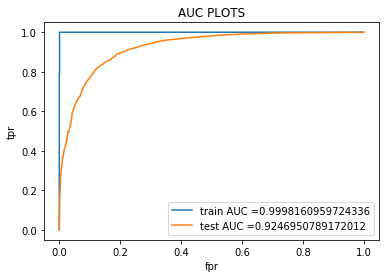

Train confusion matrix
[[ 3450     3]
 [    0 17227]]


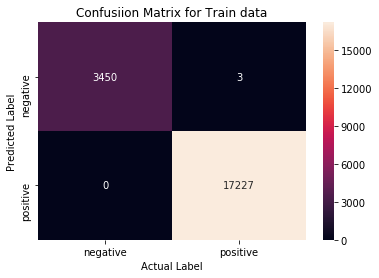

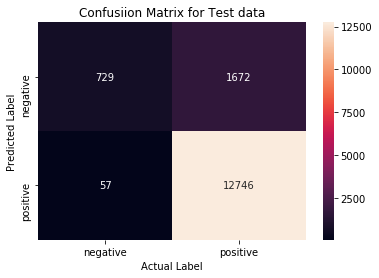

Test confusion matrix
[[  729  1672]
 [   57 12746]]
0.9246950789172012
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=750, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=140, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [140]:
auc_set2,model2=test_rf(set2ss_train,y_train,set2ss_test,y_test,op_max_d2,op_n_est2)
print(auc_set2)
print(model2)

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

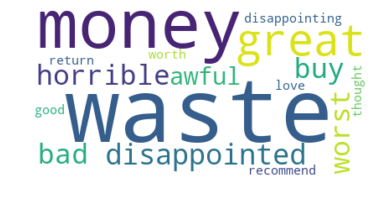

In [141]:
# Please write all the code with proper documentation
word_cloud(model2,tf_idf_vect)

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

{'max_depth': 1000, 'n_estimators': 140}
1000
140


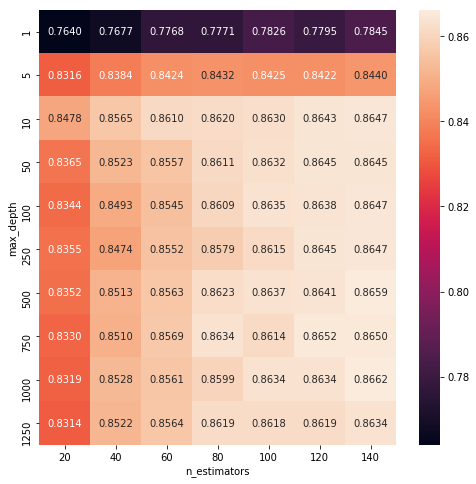

In [151]:
# Please write all the code with proper documentation
op3=gscv_rf(set3_train,y_train,set3_cv,y_cv)
op_max_d3=op3.get('max_depth')
op_n_est3=op3.get('n_estimators')
print(op_max_d3)
print(op_n_est3)

auc for Test data is:: 0.8722074295178177


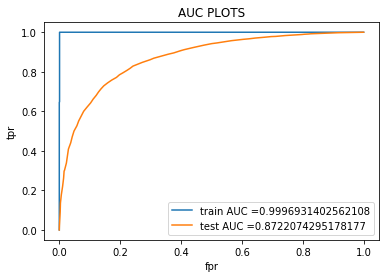

Train confusion matrix
[[ 3450     3]
 [    0 17227]]


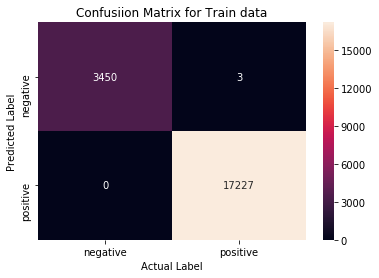

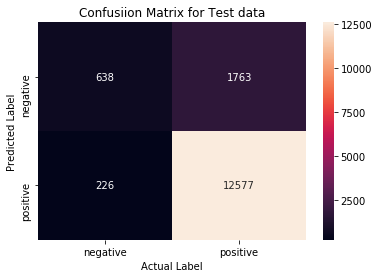

Test confusion matrix
[[  638  1763]
 [  226 12577]]
0.8722074295178177
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1000, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=140, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [152]:
auc_set3,model3=test_rf(set3_train,y_train,set3_test,y_test,op_max_d3,op_n_est3)
print(auc_set3)
print(model3)

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

{'max_depth': 250, 'n_estimators': 140}
250
140


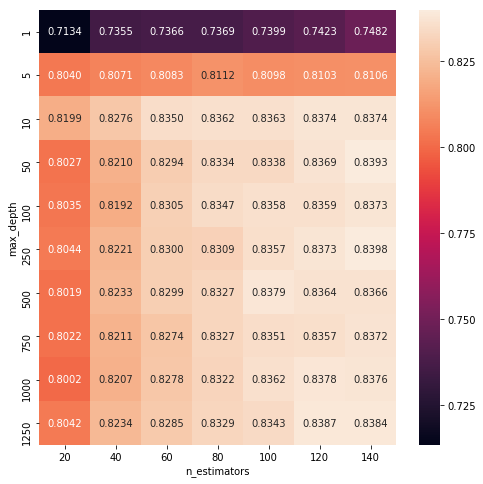

In [157]:
# Please write all the code with proper documentation
op4=gscv_rf(set4_train,y_train,set4_cv,y_cv)
op_max_d4=op4.get('max_depth')
op_n_est4=op4.get('n_estimators')
print(op_max_d4)
print(op_n_est4)

auc for Test data is:: 0.8432831480205125


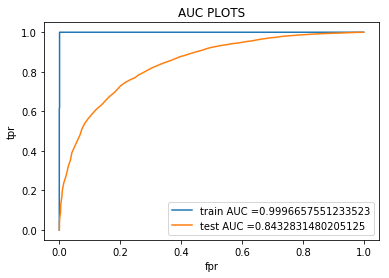

Train confusion matrix
[[ 3450     3]
 [    0 17227]]


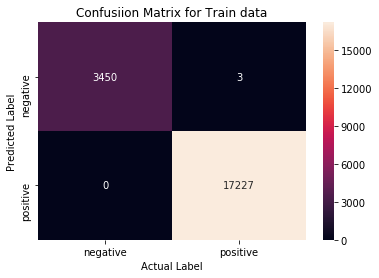

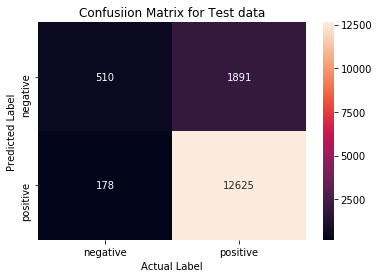

Test confusion matrix
[[  510  1891]
 [  178 12625]]
0.8432831480205125
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=250, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=140, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [158]:
auc_set4,model4=test_rf(set4_train,y_train,set4_test,y_test,op_max_d4,op_n_est4)
print(auc_set4)
print(model4)

## [5.2] Applying GBDT using XGBOOST

In [162]:
from xgboost import XGBClassifier

In [179]:
def gscv_gbdt(x_train,y_train,x_cv,y_cv):
    #params_grid = {'n_estimators' : [80,100], 'max_depth': [250,500,750]}
    params_grid = {'n_estimators' : [20,40,60,80,100,120,140], 'max_depth': [1,3,5,7,9,11,13,15]}
    xgb= XGBClassifier(booster='gbtree')

    model_xgb=GridSearchCV(xgb,params_grid,scoring='roc_auc',n_jobs=-1,cv=3)
    model_xgb.fit(x_train,y_train)

    best_par = model_xgb.best_params_
    print(best_par)
    scores = model_xgb.cv_results_['mean_test_score']
    #print(scores)
    ne=len(params_grid.get('n_estimators'))
    md=len(params_grid.get('max_depth'))
    n_e=params_grid.get('n_estimators')
    m_d=params_grid.get('max_depth')
    scores=scores.reshape(md,ne)
    df1 = pd.DataFrame(scores, index = m_d , columns =n_e )

    plt.figure(figsize=(8, 8))
    sns.heatmap(df1 , fmt=".4f", annot = True)
    plt.xlabel('n_estimators')
    plt.ylabel('max_depth')
    return(best_par)

{'max_depth': 15, 'n_estimators': 140}
{'max_depth': 15, 'n_estimators': 140}


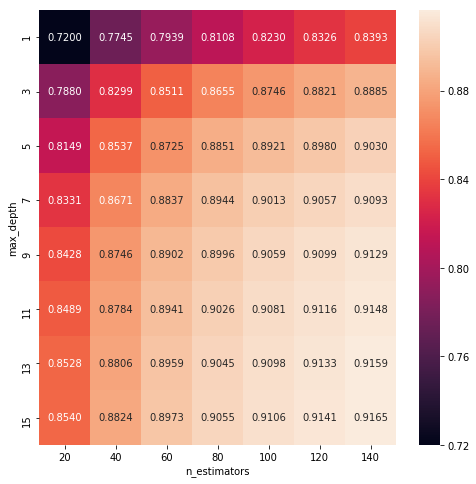

In [164]:
bp1a=gscv_gbdt(set1ss_train,y_train,set1ss_cv,y_cv)
print(bp1a)


In [165]:

op_max_d1a=bp1a.get('max_depth')
op_n_est1a=bp1a.get('n_estimators')
print(op_max_d1a)
print(op_n_est1a)

15
140


In [166]:
def test_gbdt(x_train,y_train,x_test,y_test,max_d,n_est):
    model = XGBClassifier(booster='gbtree',max_depth=max_d,n_estimators=n_est)
    model.fit(x_train,y_train)

    train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(x_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    auc_test=auc(test_fpr, test_tpr)
    print('auc for Test data is::',auc_test)

    plt.legend()
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.title("AUC PLOTS")
    plt.show()

    print("="*100)

    yhat_train=model.predict(x_train)
    yhat_test=model.predict(x_test)

    con_mat_train = confusion_matrix(y_train, yhat_train)
    con_mat_test = confusion_matrix(y_test, yhat_test)

    plt.figure()
    class_label = ["negative", "positive"]
    df_con_mat_train = pd.DataFrame(con_mat_train, index = class_label, columns = class_label)
    sns.heatmap(df_con_mat_train , annot = True, fmt = "d")
    plt.title("Confusiion Matrix for Train data")
    plt.xlabel("Actual Label")
    plt.ylabel("Predicted Label")
    print("Train confusion matrix")
    print(con_mat_train)
    plt.figure()
    class_label = ["negative", "positive"]
    df_con_mat_test = pd.DataFrame(con_mat_test, index = class_label, columns = class_label)
    sns.heatmap(df_con_mat_test , annot = True, fmt = "d")
    plt.title("Confusiion Matrix for Test data")
    plt.xlabel("Actual Label")
    plt.ylabel("Predicted Label")
    plt.show()
    print("Test confusion matrix")
    print(con_mat_test)
    return(auc_test,model)

auc for Test data is:: 0.8838560458175623


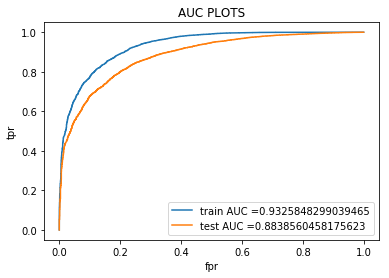

Train confusion matrix
[[   20  3433]
 [    0 17227]]


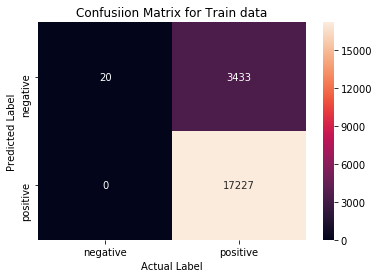

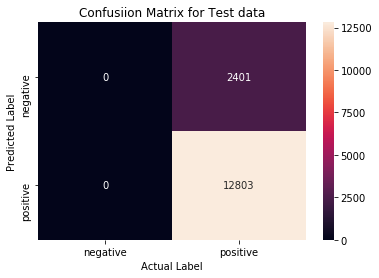

Test confusion matrix
[[    0  2401]
 [    0 12803]]
0.8838560458175623
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=140, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [167]:
auc_set1a,model1a=test_rf(set1ss_train,y_train,set1ss_test,y_test,op_max_d1a,op_n_est1a)
print(auc_set1a)
print(model1a)

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

#Wordcloud of top 20 important features from SET 1

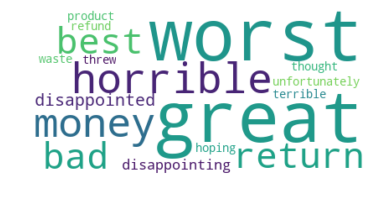

In [188]:
word_cloud(model1a,count_vect)

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

{'max_depth': 15, 'n_estimators': 140}
15
140


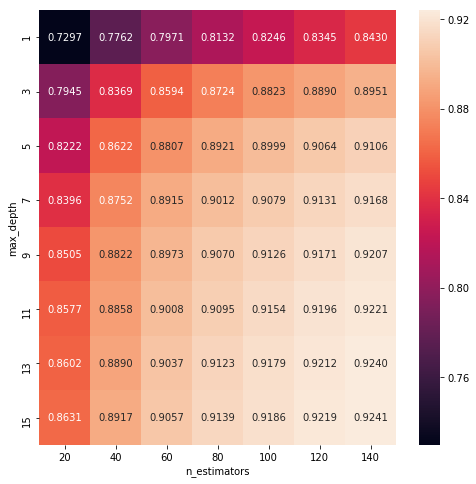

In [168]:
# Please write all the code with proper documentation
bp2a=gscv_gbdt(set2ss_train,y_train,set2ss_cv,y_cv)

op_max_d2a=bp2a.get('max_depth')
op_n_est2a=bp2a.get('n_estimators')
print(op_max_d2a)
print(op_n_est2a)

auc for Test data is:: 0.9025726835485345


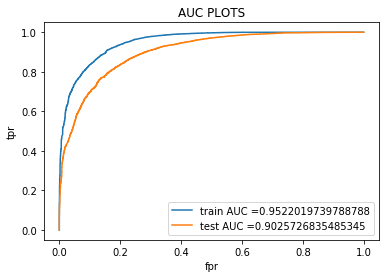

Train confusion matrix
[[   59  3394]
 [    0 17227]]


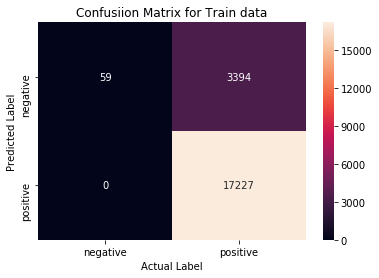

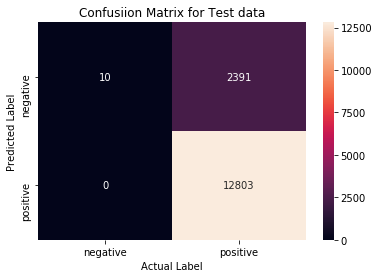

Test confusion matrix
[[   10  2391]
 [    0 12803]]
0.9025726835485345
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=140, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [169]:
# Please write all the code with proper documentation
auc_set2a,model2a=test_rf(set2ss_train,y_train,set2ss_test,y_test,op_max_d2a,op_n_est2a)
print(auc_set2a)
print(model2a)

#Wordcloud of top 20 important features from SET 2

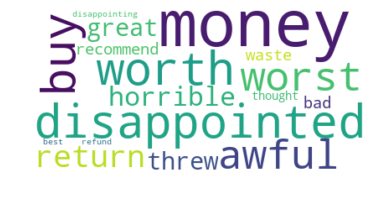

In [190]:
word_cloud(model2a,tf_idf_vect)

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

{'max_depth': 5, 'n_estimators': 120}
5
120


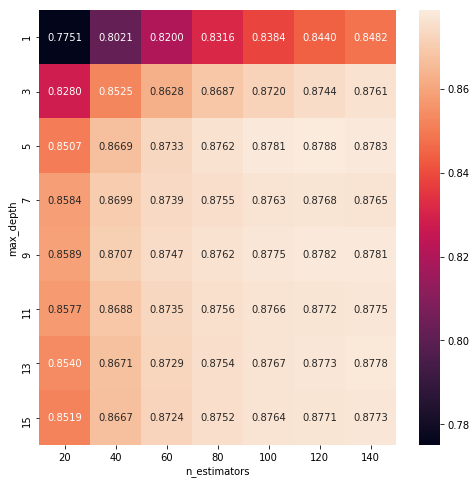

In [170]:
# Please write all the code with proper documentation
bp3a=gscv_gbdt(set3_train,y_train,set3_cv,y_cv)

op_max_d3a=bp3a.get('max_depth')
op_n_est3a=bp3a.get('n_estimators')
print(op_max_d3a)
print(op_n_est3a)


auc for Test data is:: 0.8432577576521381


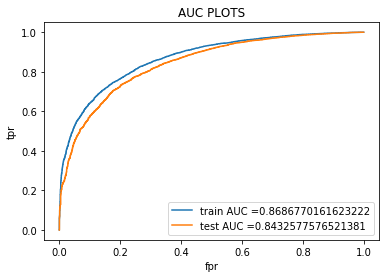

Train confusion matrix
[[  148  3305]
 [   18 17209]]


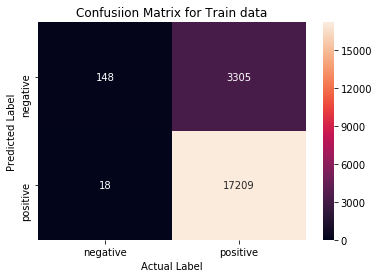

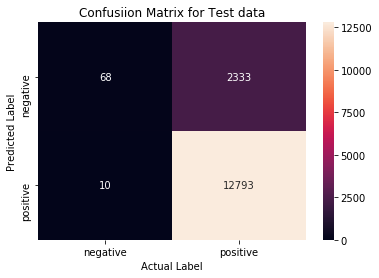

Test confusion matrix
[[   68  2333]
 [   10 12793]]
0.8432577576521381
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [171]:
# Please write all the code with proper documentation
auc_set3a,model3a=test_rf(set3_train,y_train,set3_test,y_test,op_max_d3a,op_n_est3a)
print(auc_set3a)
print(model3a)

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

{'max_depth': 13, 'n_estimators': 140}


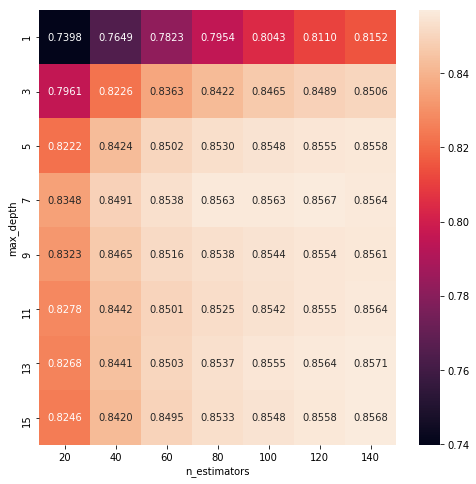

In [185]:
# Please write all the code with proper documentation
bp4a=gscv_gbdt(set4_train,y_train,set4_cv,y_cv)

In [186]:

op_max_d4a=bp4a.get('max_depth')
op_n_est4a=bp4a.get('n_estimators')
print(op_max_d4a)
print(op_n_est4a)

13
140


auc for Test data is:: 0.8444548297539203


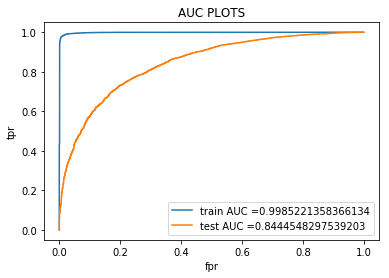

Train confusion matrix
[[ 2643   810]
 [    6 17221]]


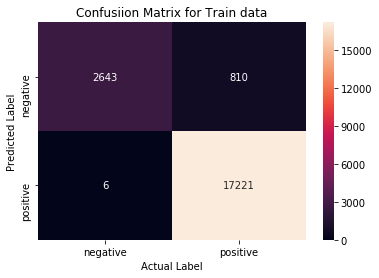

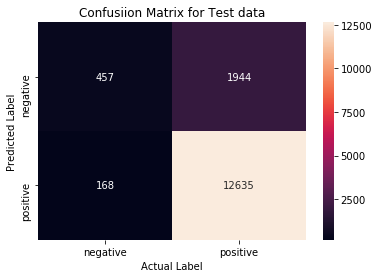

Test confusion matrix
[[  457  1944]
 [  168 12635]]
0.8444548297539203
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=13, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=140, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [187]:
# Please write all the code with proper documentation
auc_set4a,model4a=test_rf(set4_train,y_train,set4_test,y_test,op_max_d4a,op_n_est4a)
print(auc_set4a)
print(model4a)

# [6] Conclusions

In [193]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
result=PrettyTable()
result.field_names=["Vectorizer","Model","dataset","Opt_max_Depth","opt_n_estimators","AUC"]
result.add_row(["BoW","RandomForest","set1",op_max_d1,op_n_est1, auc_set1])

result.add_row(["TfIdf","RandomForest","set2",op_max_d2,op_n_est2, auc_set2])

result.add_row(["Avg W2v","RandomForest","set3",op_max_d3,op_n_est3, auc_set3])

result.add_row(["TFIDF weighted W2v","RandomForest","set4",op_max_d4,op_n_est4, auc_set4])
result.add_row(["BoW","GBDT","set1",op_max_d1a,op_n_est1a, auc_set1a])

result.add_row(["TfIdf","GBDT","set2",op_max_d2a,op_n_est2a, auc_set2a])

result.add_row(["Avg W2v","GBDT","set3",op_max_d3a,op_n_est3a, auc_set3a])

result.add_row(["TFIDF weighted W2v","GBDT","set4",op_max_d4a,op_n_est4a, auc_set4a])


print(result)

+--------------------+--------------+---------+---------------+------------------+--------------------+
|     Vectorizer     |    Model     | dataset | Opt_max_Depth | opt_n_estimators |        AUC         |
+--------------------+--------------+---------+---------------+------------------+--------------------+
|        BoW         | RandomForest |   set1  |      1000     |       140        | 0.9029759853959677 |
|       TfIdf        | RandomForest |   set2  |      750      |       140        | 0.9246950789172012 |
|      Avg W2v       | RandomForest |   set3  |      1000     |       140        | 0.8722074295178177 |
| TFIDF weighted W2v | RandomForest |   set4  |      250      |       140        | 0.8432831480205125 |
|        BoW         |     GBDT     |   set1  |       15      |       140        | 0.8838560458175623 |
|       TfIdf        |     GBDT     |   set2  |       15      |       140        | 0.9025726835485345 |
|      Avg W2v       |     GBDT     |   set3  |       5       | 

In [ ]:
#For ensembles if we use Random Forest(Bagging) we get higher values of max_depth parameter 
#whereas in case of GBDT(Boosting) we get lower values of max_depth parameter
#Optimal number of estimators (base learners)is 140 in all cases(except Avg W2V data using GBDT)
#Among all models Random Forest on TfIdf vectorizor shown best performance.